# Check distributions used in undelayed-demand




## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

## Set file paths

In [16]:
from pathlib import Path

# set file paths
data_file_path = '/Users/zellaking/Repos/patientflow/data-public/inpatient_arrivals.csv'

media_file_path = Path('media')

# create subfolders for weekdays and weekends
media_file_path_weekdays = media_file_path / 'weekdays'
media_file_path_weekends = media_file_path / 'weekends'
media_file_path_all_days = media_file_path / 'all_days'

    
media_file_path_weekdays.mkdir(parents=True, exist_ok=True)
media_file_path_weekends.mkdir(parents=True, exist_ok=True)
media_file_path_all_days.mkdir(parents=True, exist_ok=True)

## Load parameters

These are set in config.json. 

In [12]:
# Set params for aspirational curve
x1 = 4
y1 = 0.8
x2 = 12
y2 = 0.99 

print(f'The aspiration is for {y1*100}% of patients to be admitted within {x1} hours, and {y2*100}% of patients to be admitted within {x2} hours')

The aspiration is for 80.0% of patients to be admitted within 4 hours, and 99.0% of patients to be admitted within 12 hours


## Load data

Here we load the data. NOTE - the public data is a subset of UCLH arrivals, so the charts here will underestimate the demand at UCLH. 

In [23]:
import pandas
inpatient_arrivals = pd.read_csv(data_file_path)
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'])

inpatient_arrivals.set_index('arrival_datetime', inplace=True)

# select only data from 2023 onwards
# inpatient_arrivals = inpatient_arrivals[inpatient_arrivals.index > '2023-01-01']

weekdays = inpatient_arrivals[(inpatient_arrivals.index.weekday < 5) ]
weekends = inpatient_arrivals[(inpatient_arrivals.index.weekday >= 5) ]

In [24]:
inpatient_arrivals

,training_validation_test,sex,specialty,is_child
arrival_datetime,,,,
2031-04-24 19:21:00+00:00,train,M,haem/onc,False
2031-04-25 12:42:00+00:00,train,F,medical,False
2031-03-20 19:54:00+00:00,train,F,haem/onc,False
2031-03-04 22:03:00+00:00,train,F,haem/onc,False
2031-03-01 11:10:44+00:00,train,M,surgical,False
...,...,...,...,...
2031-10-27 02:47:29+00:00,test,M,NaN,False
2031-10-27 02:49:19+00:00,test,F,NaN,False
2031-10-27 02:52:40+00:00,test,F,NaN,False



Whole dataset
Mean: 41.4216
Variance: 73.7856
Variance-to-Mean Ratio: 1.7813


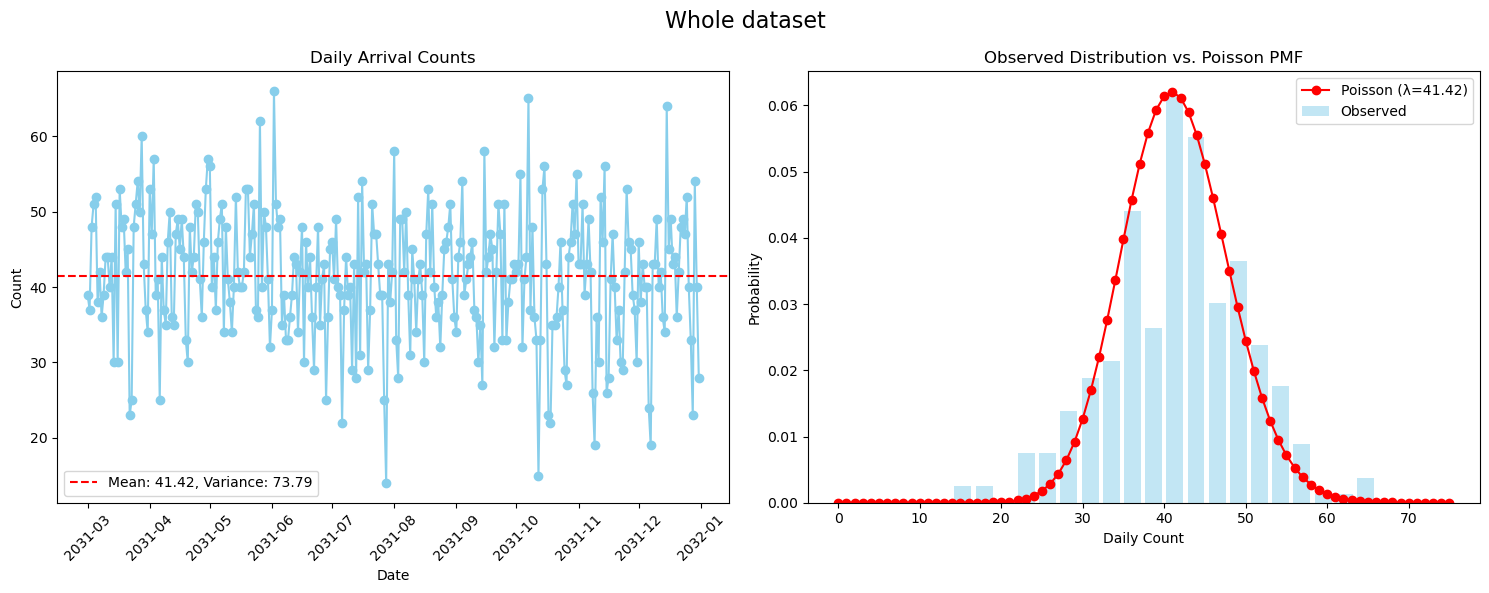


Weekdays
Mean: 44.3394
Variance: 54.1515
Variance-to-Mean Ratio: 1.2213


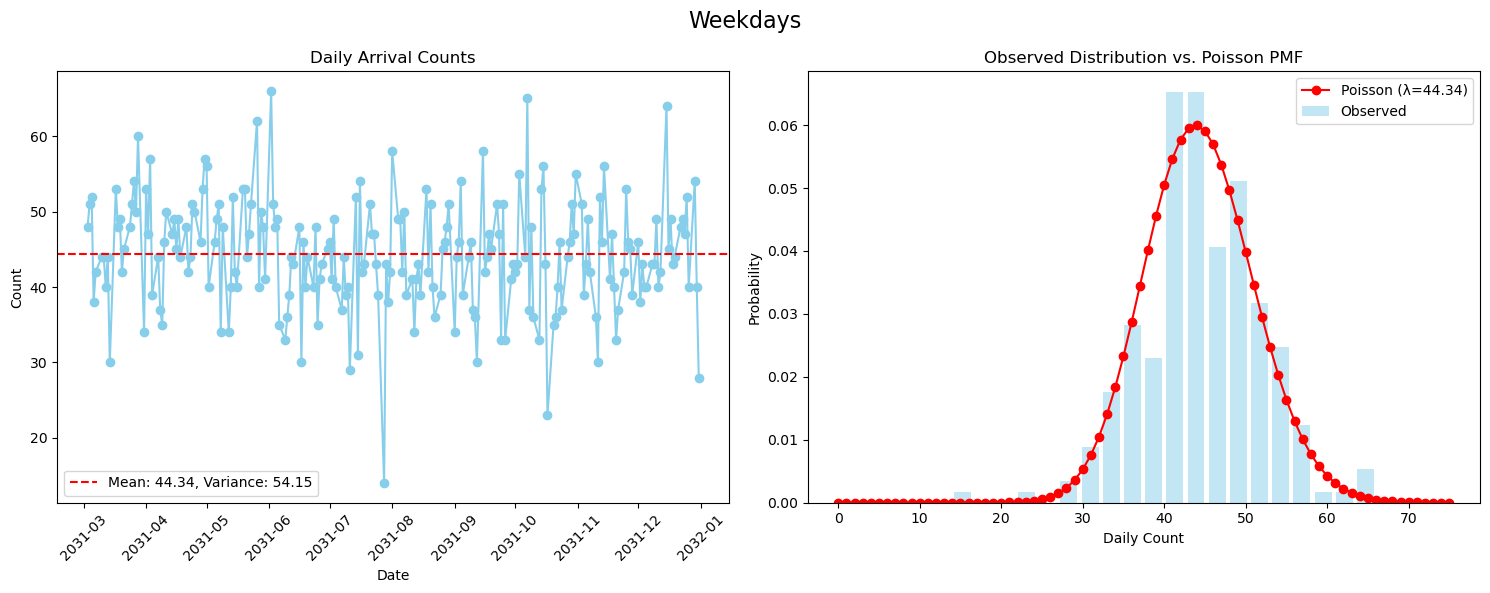


Weekends
Mean: 34.1932
Variance: 49.4220
Variance-to-Mean Ratio: 1.4454


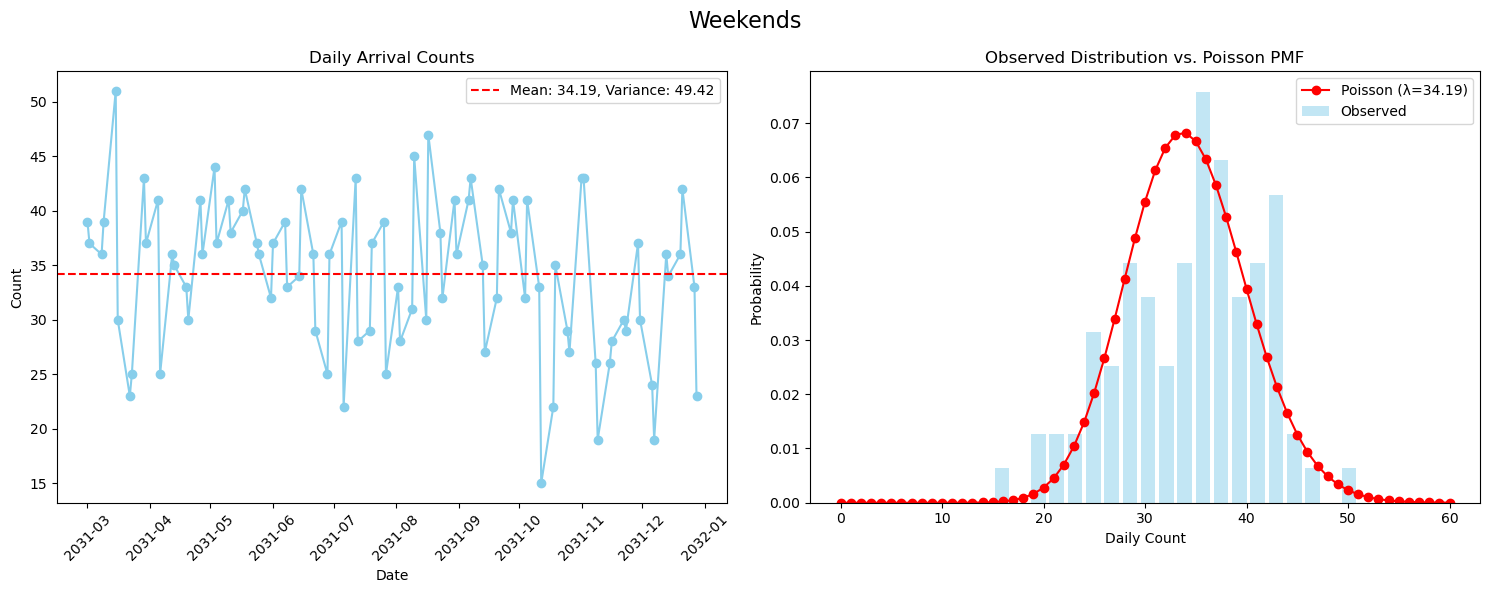

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def compare_with_poisson(df, suptitle):

    print(f"\n{suptitle}")

    df = df.copy(deep=True).reset_index()

    # After calculating the daily counts
    daily_counts = df.groupby(df['arrival_datetime'].dt.date).size()
    daily_counts_df = daily_counts.reset_index(name='count')
    
    # Calculate mean and variance
    mean_count = daily_counts_df['count'].mean()
    variance_count = daily_counts_df['count'].var()
    
    # Print the comparison
    print(f"Mean: {mean_count:.4f}")
    print(f"Variance: {variance_count:.4f}")
    print(f"Variance-to-Mean Ratio: {variance_count/mean_count:.4f}")
    
    
    
    # Generate Poisson PMF based on the mean
    max_count = daily_counts_df['count'].max()
    count_range = np.arange(0, max_count + 10)
    poisson_pmf = stats.poisson.pmf(k=count_range, mu=mean_count)
    
    # Create the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(suptitle, fontsize=16)

    
    # Plot 1: Daily counts over time
    ax1.plot(daily_counts_df['arrival_datetime'], daily_counts_df['count'], 'o-', color='skyblue')
    ax1.axhline(mean_count, color='red', linestyle='--', label=f'Mean: {mean_count:.2f}, Variance: {variance_count:.2f}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Count')
    ax1.set_title('Daily Arrival Counts')
    ax1.legend()
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Comparison with Poisson distribution
    # Histogram of observed counts
    n_bins = min(20, max_count + 1)  # Adjust number of bins based on max count
    observed_hist, bins = np.histogram(daily_counts_df['count'], bins=n_bins, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    ax2.bar(bin_centers, observed_hist, width=(bins[1]-bins[0])*0.8, alpha=0.5, color='skyblue', label='Observed')
    ax2.plot(count_range, poisson_pmf, 'ro-', label=f'Poisson (λ={mean_count:.2f})')
    ax2.set_xlabel('Daily Count')
    ax2.set_ylabel('Probability')
    ax2.set_title('Observed Distribution vs. Poisson PMF')
    ax2.legend()

    plt.tight_layout()
    plt.show()


compare_with_poisson(inpatient_arrivals, "Whole dataset")
compare_with_poisson(weekdays, "Weekdays")
compare_with_poisson(weekends, "Weekends")